`Notebook: 03_model.ipynb`

- Purpose:

   - Market-Driven Prediction Accuracy
   - Business Usability & Interpretability
   - Deployment Readiness & Scalability

## 1.Packages Import

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
from pathlib import Path
import yaml
from tqdm import tqdm
import pickle
from shap import initjs
import xgboost
import shap
import IPython.display as display 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

initjs()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# sys.path.append("../scripts")

import plotly.io as pio
pio.renderers.default = 'vscode'  # or 'notebook'

sys.path.append(os.path.abspath("../scripts"))  # Adjust the path
os.chdir(os.path.dirname(os.path.abspath("__file__")))  # Set working directory

from utils import *


## 2.Dataset Loading

In [2]:
# Save as Parquet
df_optimized_merged = pd.read_parquet('../datasets/processed/df_optimized_merged.parquet', engine='fastparquet')

In [3]:
df_optimized_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841648 entries, 0 to 841647
Columns: 126 entries, start_date to other_conventional_mw_installed_gen
dtypes: UInt32(1), category(2), datetime64[ns](4), float32(115), float64(3), int8(1)
memory usage: 420.6 MB


In [4]:
df_optimized_merged.columns

Index(['start_date', 'end_date_x', 'region_type', 'region_name',
       'day_ahead_price_€/MWh', 'hour_of_day', 'date', 'week_of_year',
       'hydro_pumped_storage_actual_consum', 'residual_load_actual_consum',
       ...
       'hydropower_mw_installed_gen', 'wind_offshore_mw_installed_gen',
       'wind_onshore_mw_installed_gen', 'photovoltaics_mw_installed_gen',
       'other_renewable_mw_installed_gen', 'lignite_mw_installed_gen',
       'hard_coal_mw_installed_gen', 'fossil_gas_mw_installed_gen',
       'hydro_pumped_storage_mw_installed_gen',
       'other_conventional_mw_installed_gen'],
      dtype='object', length=126)

In [5]:
cols_to_drop = ['start_date', 'end_date_x', 'end_date_y', 'region_type', 'region_name', 'date']

df_analysis = df_optimized_merged.drop(columns=cols_to_drop)

In [6]:
df_optimized_merged[['start_date', 'end_date_x', 'end_date_y','region_type', 'region_name', 'hour_of_day',
       'date', 'week_of_year', 'hydro_pumped_storage_actual_consum',
       'residual_load_actual_consum', 'total_grid_load_actual_consum',
       'hydropower_mw_installed_gen', 'wind_offshore_mw_installed_gen',
       'wind_onshore_mw_installed_gen', 'photovoltaics_mw_installed_gen',
       'other_renewable_mw_installed_gen', 'lignite_mw_installed_gen',
       'hard_coal_mw_installed_gen', 'fossil_gas_mw_installed_gen',
       'hydro_pumped_storage_mw_installed_gen',
       'other_conventional_mw_installed_gen']].head().T

,0,1,2,3,4
start_date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
end_date_x,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00,2023-01-01 01:00:00
end_date_y,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00
region_type,bidding_zone,bidding_zone,bidding_zone,bidding_zone,bidding_zone
region_name,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg,germany/luxembourg
hour_of_day,0,0,0,0,0
date,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01 00:00:00
week_of_year,52,52,52,52,52
hydro_pumped_storage_actual_consum,494.0,494.0,494.0,494.0,494.0
residual_load_actual_consum,1842.5,1842.5,1842.5,1842.5,1842.5


## 3.Modelling

In [7]:

df_optimized_merged.isnull().mean() * 100

start_date                                0.000000
end_date_x                                0.000000
region_type                               6.250000
region_name                               0.000000
day_ahead_price_€/MWh                     1.487439
                                           ...    
lignite_mw_installed_gen                 37.551090
hard_coal_mw_installed_gen               37.551090
fossil_gas_mw_installed_gen              37.551090
hydro_pumped_storage_mw_installed_gen    37.551090
other_conventional_mw_installed_gen      37.551090
Length: 126, dtype: float64

- will be handled dynamically

In [8]:
#  Function to handle missing values
def handle_missing_data(df, drop_threshold=90):
    """Drop columns with > drop_threshold% missing & interpolate remaining NaNs."""
    df_cleaned = df.copy()
    # Step 1: Drop columns with >90% missing values
    missing_percent = df.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > drop_threshold].index.tolist()
    df_cleaned = df.drop(columns=cols_to_drop)
    
    # Step 2: Fill remaining missing values
    # df_cleaned.interpolate(method='linear', inplace=True)  # Interpolate linearly
    df_cleaned.fillna(method='ffill', inplace=True)  # Forward fill
    df_cleaned.fillna(method='bfill', inplace=True)  # Backward fill (if needed)

    return df_cleaned

df_optimized_merged = handle_missing_data(df_optimized_merged)

df_optimized_merged.isnull().mean().sum()

np.float64(0.0)

In [9]:
df_optimized_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841648 entries, 0 to 841647
Columns: 126 entries, start_date to other_conventional_mw_installed_gen
dtypes: UInt32(1), category(2), datetime64[ns](4), float32(115), float64(3), int8(1)
memory usage: 420.6 MB


In [10]:
def preprocess_data(df, target_col):
    """
    Prepares the dataset for training by handling missing values, scaling features, and splitting into train-test sets.
    """
    # Drop irrelevant columns
    drop_cols = ['start_date', 'end_date_x', 'end_date_y', 'region_type', 'region_name', 'date']
    if drop_cols:
        df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
     
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert Inf to NaN
    df.dropna(inplace=True)  # Remove rows with NaNs    

    # Handle missing data
    df = df.dropna(subset=[target_col])  # Remove rows where target is missing
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Standardize features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Define target and features
    features = [col for col in df_scaled.columns if col != target_col]

    # Split into train and test sets (80-20)
    X_train, X_test, y_train, y_test = train_test_split(df_scaled[features], df_scaled[target_col], test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, df_scaled


In [66]:
# def train_model(X_train, y_train, X_test, model_type='rf', n_estimators=5):
#     """
#     Trains a machine learning model (Random Forest or Linear Regression) and returns predictions.
#     """
#     if model_type == 'rf':
#         model = RandomForestRegressor(n_estimators=1, random_state=42, warm_start=True, n_jobs=-1)
        
#         # Training loop with incremental estimators
#         for i in tqdm(range(3, n_estimators + 1), desc="Training Random Forest", unit="trees"):
#             model.n_estimators = i  
#             model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)
    
#     elif model_type == 'lr':
#         model = LinearRegression()
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)

#     else:
#         raise ValueError("Unsupported model type. Choose 'rf' or 'lr'.")

#     return model, y_pred

import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def train_model(X_train, y_train, X_test, model_type='rf', n_estimators=5):
    """
    Trains a machine learning model (Random Forest, XGBoost, or Linear Regression) and returns predictions.
    
    Parameters:
    - X_train (DataFrame): Training feature set
    - y_train (Series): Target variable for training
    - X_test (DataFrame): Test feature set
    - model_type (str): Model type ('rf' for Random Forest, 'lr' for Linear Regression, 'xgb' for XGBoost)
    - n_estimators (int): Number of estimators (for 'rf' and 'xgb')

    Returns:
    - model: Trained model
    - y_pred (array): Predictions on X_test
    """

    if model_type == 'rf':
        model = RandomForestRegressor(n_estimators=1, random_state=42, warm_start=True, n_jobs=-1)
        
        # Incrementally train Random Forest
        for i in tqdm(range(3, n_estimators + 1), desc="Training Random Forest", unit="trees"):
            model.n_estimators = i  
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

    elif model_type == 'xgb':
        model = xgb.XGBRegressor(n_estimators=n_estimators, random_state=42, objective='reg:squarederror')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    elif model_type == 'lr':
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    else:
        raise ValueError("Unsupported model type. Choose 'rf', 'xgb', or 'lr'.")

    return model, y_pred


def evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, features, df_scaled, target_col):
    """
    Computes multiple evaluation metrics for the trained models.
    """
    results = {}

    # Compute RMSE
    results["RMSE_RF"] = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    results["RMSE_LR"] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    # Directional Accuracy
    direction_actual = np.sign(y_test.diff()).dropna().reset_index(drop=True)
    direction_pred_rf = np.sign(pd.Series(y_pred_rf).diff()).dropna().reset_index(drop=True)
    direction_pred_lr = np.sign(pd.Series(y_pred_lr).diff()).dropna().reset_index(drop=True)

    results["Directional_Accuracy_RF"] = (direction_actual == direction_pred_rf).mean() * 100
    results["Directional_Accuracy_LR"] = (direction_actual == direction_pred_lr).mean() * 100

    # Volatility Capture
    actual_volatility = y_test.std()
    predicted_volatility_rf = np.std(y_pred_rf)
    results["Volatility_Capture"] = (predicted_volatility_rf / actual_volatility) * 100

    # Extreme Price Movement Detection
    actual_change = y_test.pct_change().dropna()
    predicted_change_rf = pd.Series(y_pred_rf).pct_change().dropna()
    extreme_threshold = actual_change.abs().quantile(0.95)

    actual_extreme = actual_change.abs() >= extreme_threshold
    predicted_extreme_rf = predicted_change_rf.abs() >= extreme_threshold

    # Align indices before comparison
    actual_extreme = actual_extreme.reset_index(drop=True)
    predicted_extreme_rf = predicted_extreme_rf.reset_index(drop=True)

    results["Extreme_Movement_Accuracy_RF"] = (actual_extreme == predicted_extreme_rf).mean() * 100

    # Confidence Interval Coverage (95%)
    residuals = y_test - y_pred_rf
    lower_percentile = np.percentile(residuals, 2.5)
    upper_percentile = np.percentile(residuals, 97.5)
    results["Confidence_Interval_Coverage"] = ((residuals >= lower_percentile) & (residuals <= upper_percentile)).mean() * 100

    # Feature Importance (for Random Forest only)
    importances = rf_model.feature_importances_
    feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
    results["Top_Features"] = feature_importance.head(10)

    # Correlation Analysis
    df_corr = df_scaled.corr()[target_col].sort_values(ascending=False)
    results["Top_Correlated_Features"] = df_corr.head(15)

    return results


In [12]:
# ---- MAIN EXECUTION ----
df = df_analysis.copy()  # Ensure the dataset is copied
target_col = 'germany/luxembourg_€/mwh'  # Define the target variable

# Preprocess data
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df, target_col)

# Train Random Forest model
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=5)

# Train Linear Regression model
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')


Training Random Forest: 100%|██████████| 3/3 [00:00<00:00,  5.71trees/s]


In [13]:
# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price:")
print(metrics["Top_Correlated_Features"])



Evaluation Metrics:
RMSE_RF: 0.000000
RMSE_LR: 0.000000
Directional_Accuracy_RF: 100.000000
Directional_Accuracy_LR: 100.000000
Volatility_Capture: 99.999287
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 100.000000

Top 10 Feature Importances:
netherlands_export_scheduled               0.2
fossil_gas_mw_installed_gen                0.2
france_export_cross_border                 0.2
france_import_scheduled                    0.2
volume_procured_down_manualfreq_mw         0.2
procured_reserve_up_autofreq_mw            0.0
photovoltaics_mwh_gen_forecast             0.0
photovoltaics_and_wind_mwh_gen_forecast    0.0
year_freq_containm                         0.0
procurement_price_€/mw_freq_containm       0.0
dtype: float64

Top 15 Correlated Features with Target Price:
netherlands_import_scheduled               1.0
poland_€/mwh                               1.0
sweden_4_€/mwh                             1.0
belgium_€/mwh                              1.0
wind_offsh

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70080 entries, 280320 to 350399
Columns: 119 entries, day_ahead_price_€/MWh to other_conventional_mw_installed_gen
dtypes: float64(119)
memory usage: 64.2 MB


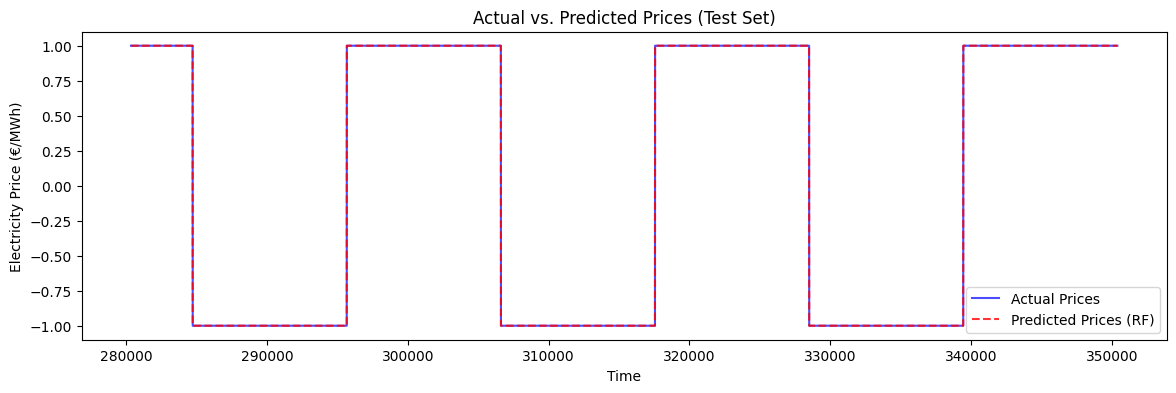

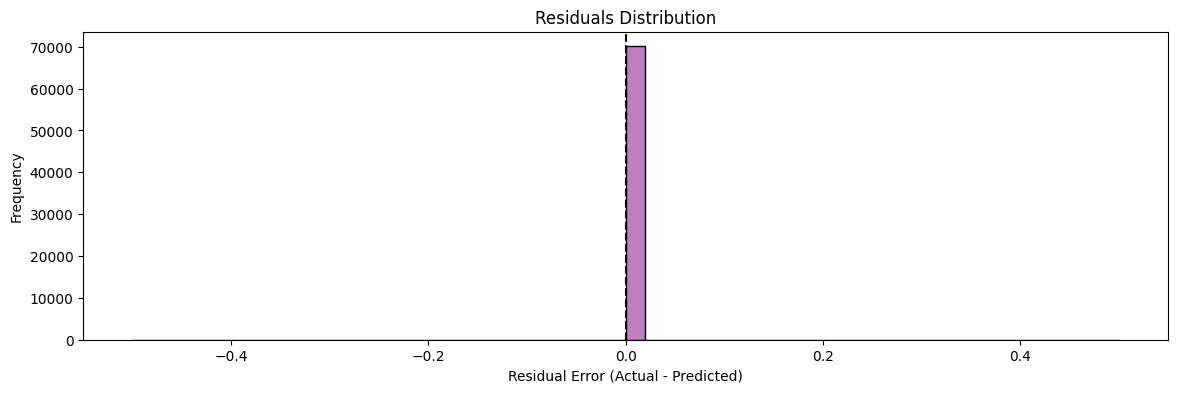

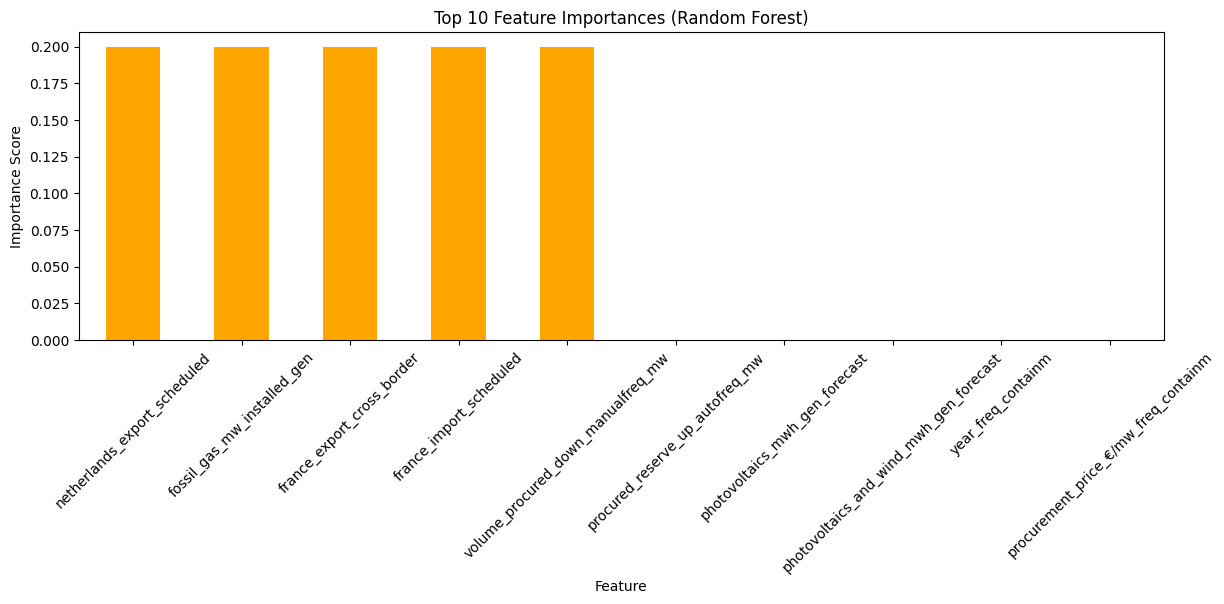

netherlands_export_scheduled               0.2
fossil_gas_mw_installed_gen                0.2
france_export_cross_border                 0.2
france_import_scheduled                    0.2
volume_procured_down_manualfreq_mw         0.2
procured_reserve_up_autofreq_mw            0.0
photovoltaics_mwh_gen_forecast             0.0
photovoltaics_and_wind_mwh_gen_forecast    0.0
year_freq_containm                         0.0
procurement_price_€/mw_freq_containm       0.0
dtype: float64

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1️ Actual vs. Predicted Prices Plot (1-Hour Ahead)
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test, label="Actual Prices", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred_rf, label="Predicted Prices (RF)", color="red", linestyle="dashed", alpha=0.8)
plt.title("Actual vs. Predicted Prices (Test Set)")
plt.xlabel("Time")
plt.ylabel("Electricity Price (€/MWh)")
plt.legend()
plt.show()

# # 2. Residuals Distribution (Error Analysis)
residuals = y_test - y_pred_rf
plt.figure(figsize=(14, 4))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.axvline(0, color="black", linestyle="dashed")
plt.title("Residuals Distribution")
plt.xlabel("Residual Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# # 3 Directional Accuracy Visualization (Up/Down Movements)
# plt.figure(figsize=(14, 4))
# plt.plot(y_test.index,  direction_actual, label="Actual Direction", color="black", alpha=0.6)
# plt.plot(y_test.index, direction_pred_rf, label="Predicted Direction (RF)", color="red", linestyle="dashed", alpha=0.8)
# plt.title("Directional Accuracy (1-Hour Ahead)")
# plt.xlabel("Time")
# plt.ylabel("Price Movement Direction")
# plt.legend()
# plt.show()

# top_features = feature_importance.head(10)
# # 4 Feature Importance Visualization
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']

In [16]:
# df_scaled.info()

# explainer = shap.TreeExplainer(rf_model)
# shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
# shap_values = explainer.shap_values(X_test.sample(1000, random_state=42))  # Sampled subset


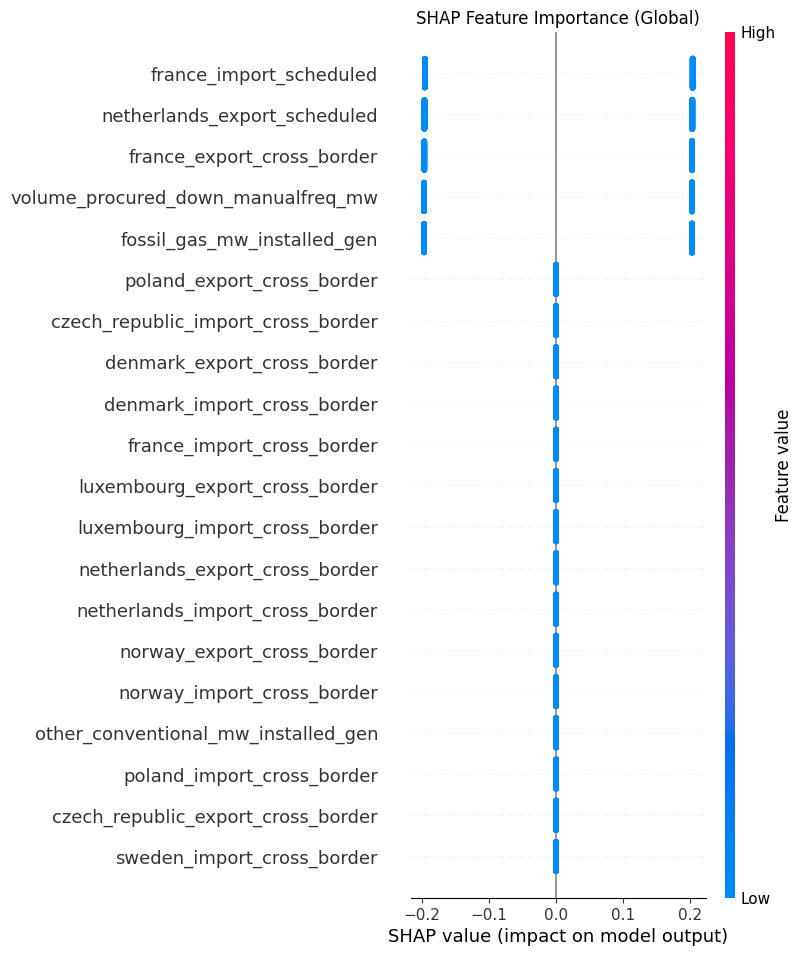

In [17]:
    
# SHAP Explainer (Tree-based models vs others)
# if hasattr(m, "predict_proba") or hasattr(model, "feature_importances_"):
#     explainer = shap.TreeExplainer(model)
# else:
#     explainer = shap.Explainer(model, X_train)

# shap_values = explainer(X_test)

##  SHAP Global Feature Importance (Static Plot)
# shap.summary_plot(shap_values, X_test[:1000], show=False)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global)")
plt.show()

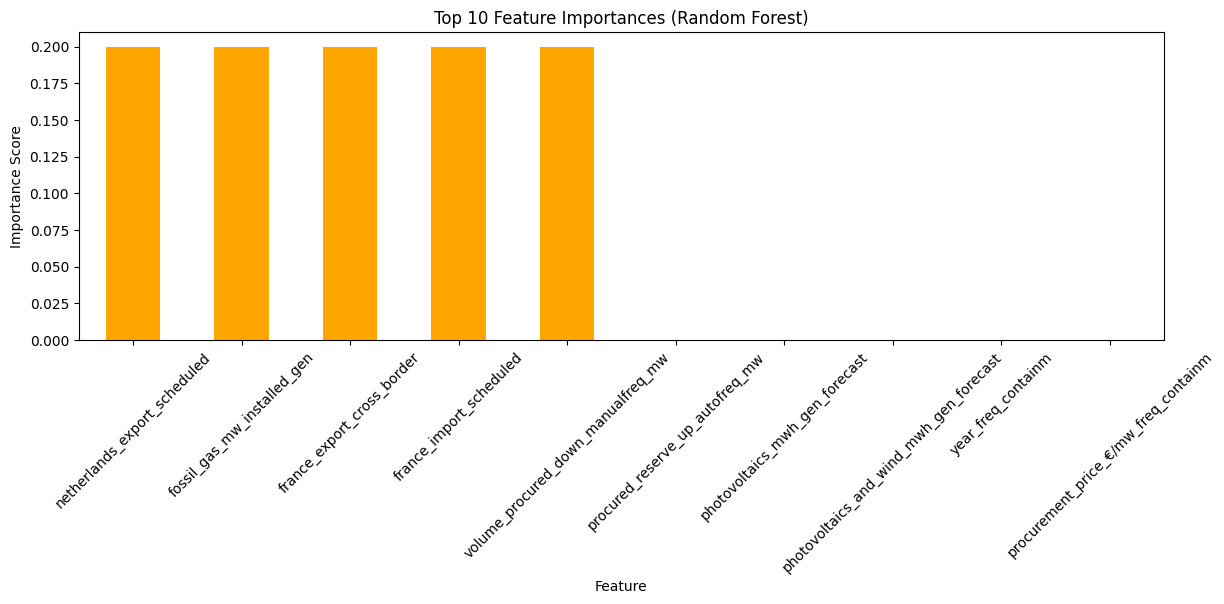

netherlands_export_scheduled               0.2
fossil_gas_mw_installed_gen                0.2
france_export_cross_border                 0.2
france_import_scheduled                    0.2
volume_procured_down_manualfreq_mw         0.2
procured_reserve_up_autofreq_mw            0.0
photovoltaics_mwh_gen_forecast             0.0
photovoltaics_and_wind_mwh_gen_forecast    0.0
year_freq_containm                         0.0
procurement_price_€/mw_freq_containm       0.0
dtype: float64

In [18]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']

In [19]:
correlations = df[df.select_dtypes(include='number').columns].corr()['germany/luxembourg_€/mwh'].drop('germany/luxembourg_€/mwh')
selected_features = correlations[abs(correlations) > 0.2].index.tolist()
correlations

day_ahead_price_€/MWh                    0.682774
hour_of_day                              0.689798
week_of_year                             0.072923
hydro_pumped_storage_actual_consum      -0.294513
residual_load_actual_consum              0.924301
                                           ...   
lignite_mw_installed_gen                -0.563416
hard_coal_mw_installed_gen              -0.801696
fossil_gas_mw_installed_gen              0.978270
hydro_pumped_storage_mw_installed_gen    0.306686
other_conventional_mw_installed_gen      0.695290
Name: germany/luxembourg_€/mwh, Length: 119, dtype: float64

In [20]:
target_col

'germany/luxembourg_€/mwh'

In [21]:
# Compute correlation with the target variable
correlations = df[df.select_dtypes(include='number').columns].corr()[target_col].dropna().sort_values(ascending=False)

# Select top 10 positively and negatively correlated features
top_positive = correlations.head(10)  # Top 10 positive correlations
top_negative = correlations.tail(10)  # Top 10 negative correlations

# Combine them into a DataFrame
top_features = pd.concat([top_positive, top_negative]).reset_index()
top_features.columns = ['Feature', 'Correlation']

# Display the DataFrame
print(top_features)


                                      Feature  Correlation
0                    germany/luxembourg_€/mwh     1.000000
1              photovoltaics_mw_installed_gen     0.987904
2                           netherlands_€/mwh     0.978353
3                 fossil_gas_mw_installed_gen     0.978270
4                    ∅_de/lu_neighbours_€/mwh     0.975676
5                               belgium_€/mwh     0.968115
6                        czech_republic_€/mwh     0.964218
7                             denmark_1_€/mwh     0.957451
8         residual_load_mwh_forecasted_consum     0.938136
9               wind_onshore_mw_installed_gen     0.935709
10              wind_onshore_mwh_gen_forecast    -0.790101
11            wind_onshore_mwh_forecasted_gen    -0.796897
12                 hard_coal_mw_installed_gen    -0.801696
13  photovoltaics_and_wind_mwh_forecasted_gen    -0.805085
14                 norway_import_cross_border    -0.815219
15                    norway_import_scheduled    -0.8190

In [22]:
# Get the top 5 positive and top 5 negative correlations
top_positive_cols = correlations.tail(5).index.tolist()  # 5 highest correlations
top_negative_cols = correlations.head(5).index.tolist()  # 5 lowest (most negative) correlations

# Combine selected columns
selected_columns = top_negative_cols + top_positive_cols
print("Selected Columns:", selected_columns)

# Filter the original dataframe
df_selected = df_optimized_merged[selected_columns]

# Display first few rows
# df_selected.head()


Selected Columns: ['germany/luxembourg_€/mwh', 'photovoltaics_mw_installed_gen', 'netherlands_€/mwh', 'fossil_gas_mw_installed_gen', '∅_de/lu_neighbours_€/mwh', 'norway_import_scheduled', 'sweden_export_cross_border', 'norway_export_cross_border', 'sweden_export_scheduled', 'norway_export_scheduled']


- Refininement and Further Training

In [23]:

# def select_best_features_shap_rf(shap_values, rf_importance, X, top_n=10):
#     """
#     Selects the best features by combining SHAP values and RF feature importance.
    
#     Parameters:
#     - shap_values: SHAP computed feature importances (array-like)
#     - rf_importance: Random Forest feature importances (array-like)
#     - X: DataFrame of features
#     - top_n: Number of best features to select
    
#     Returns:
#     - best_features: List of top selected feature names
#     - feature_ranks: DataFrame with combined importance scores
#     """
#     # Normalize both feature importance values
#     rf_importance /= np.sum(rf_importance)
#     shap_importance = np.abs(shap_values).mean(axis=0)  # Take mean over SHAP samples
#     shap_importance /= np.sum(shap_importance)

#     # Create a DataFrame of combined feature importance
#     feature_ranks = pd.DataFrame({
#         'Feature': X.columns,
#         'SHAP_Importance': shap_importance,
#         'RF_Importance': rf_importance,
#         'Avg_Importance': (shap_importance + rf_importance) / 2
#     })

#     # Sort by average importance and select top N
#     feature_ranks = feature_ranks.sort_values(by='Avg_Importance', ascending=False)
#     best_features = feature_ranks.head(top_n)['Feature'].tolist()

#     print("\n **Selected Features (SHAP + RF Combined):**")
#     print(feature_ranks.head(top_n))

#     return best_features, feature_ranks


# # best_features, feature_ranks  = select_best_features_shap_rf(shap_values, metrics['Top_Features'], X_train, top_n=10)

In [24]:
print("RF Feature Importance:")
metrics['Top_Features']


RF Feature Importance:


netherlands_export_scheduled               0.2
fossil_gas_mw_installed_gen                0.2
france_export_cross_border                 0.2
france_import_scheduled                    0.2
volume_procured_down_manualfreq_mw         0.2
procured_reserve_up_autofreq_mw            0.0
photovoltaics_mwh_gen_forecast             0.0
photovoltaics_and_wind_mwh_gen_forecast    0.0
year_freq_containm                         0.0
procurement_price_€/mw_freq_containm       0.0
dtype: float64

In [25]:
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.20003738,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.20004658, 0.        , 0.        ,
       0.20003973, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [26]:
feature_names = X_train.columns


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

print("SHAP Feature Importance:")
shap_importance.head(10)

SHAP Feature Importance:


,col_name,feature_importance_vals
57,france_import_scheduled,0.200047
60,netherlands_export_scheduled,0.200040
34,france_export_cross_border,0.200037
78,volume_procured_down_manualfreq_mw,0.200033
116,fossil_gas_mw_installed_gen,0.200033
75,procured_reserve_up_autofreq_mw,0.000000
86,photovoltaics_mwh_gen_forecast,0.000000
85,photovoltaics_and_wind_mwh_gen_forecast,0.000000
84,year_freq_containm,0.000000
83,procurement_price_€/mw_freq_containm,0.000000


In [27]:
# X_trainimport numpy as np
import pandas as pd

def select_best_features_shap_rf(rf_importance, shap_importance, top_n=10):
    """
    Selects the best features by combining SHAP values and RF feature importance.
    
    Parameters:
    - rf_importance: Pandas Series of RF feature importances
    - shap_importance: Pandas DataFrame with SHAP feature importances (col_name, feature_importance_vals)
    - top_n: Number of best features to select
    
    Returns:
    - best_features: List of top selected feature names
    - feature_ranks: DataFrame with combined importance scores
    """

    # Normalize both importance values
    rf_importance_norm = rf_importance / rf_importance.sum()
    shap_importance_norm = shap_importance.copy()
    shap_importance_norm['feature_importance_vals'] /= shap_importance_norm['feature_importance_vals'].sum()

    # Merge both importance scores
    feature_ranks = pd.merge(
        shap_importance_norm,
        rf_importance_norm.rename("RF_Importance").reset_index().rename(columns={'index': 'col_name'}),
        on="col_name",
        how="inner"
    )

    # Compute combined ranking
    feature_ranks["Avg_Importance"] = (feature_ranks["feature_importance_vals"] + feature_ranks["RF_Importance"]) / 2

    # Sort by the combined importance score
    feature_ranks = feature_ranks.sort_values(by="Avg_Importance", ascending=False)

    # Select top N features
    best_features = feature_ranks.head(top_n)['col_name'].tolist()

    print("\n **Selected Features (SHAP + RF Combined):**")
    print(feature_ranks.head(top_n))

    return best_features, feature_ranks

# Call the function
best_features, feature_ranks = select_best_features_shap_rf(metrics['Top_Features'], shap_importance, top_n=10)



 **Selected Features (SHAP + RF Combined):**
                                  col_name  feature_importance_vals  \
0                  france_import_scheduled                 0.200008   
1             netherlands_export_scheduled                 0.200002   
2               france_export_cross_border                 0.199999   
3       volume_procured_down_manualfreq_mw                 0.199995   
4              fossil_gas_mw_installed_gen                 0.199995   
5          procured_reserve_up_autofreq_mw                 0.000000   
6           photovoltaics_mwh_gen_forecast                 0.000000   
7  photovoltaics_and_wind_mwh_gen_forecast                 0.000000   
8                       year_freq_containm                 0.000000   
9     procurement_price_€/mw_freq_containm                 0.000000   

   RF_Importance  Avg_Importance  
0            0.2        0.200004  
1            0.2        0.200001  
2            0.2        0.200000  
3            0.2        0.199998

In [28]:
best_features

['france_import_scheduled',
 'netherlands_export_scheduled',
 'france_export_cross_border',
 'volume_procured_down_manualfreq_mw',
 'fossil_gas_mw_installed_gen',
 'procured_reserve_up_autofreq_mw',
 'photovoltaics_mwh_gen_forecast',
 'photovoltaics_and_wind_mwh_gen_forecast',
 'year_freq_containm',
 'procurement_price_€/mw_freq_containm']

In [29]:
# df_selected = df_optimized_merged[best_features + target_col]
df_selected = df_optimized_merged[best_features + [target_col]]

# Preprocess data
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected, target_col,)

# Train Random Forest model
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=10)

# Train Linear Regression model
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed!")



Training Random Forest: 100%|██████████| 8/8 [00:06<00:00,  1.30trees/s]

Model Training Completed!


- Next we check the metrics after Refinement

In [30]:
# df_selected = df_optimized_merged[best_features + target_col]
df_selected = df_optimized_merged[best_features + [target_col]]

# Preprocess data
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected, target_col,)

# Train Random Forest model
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=10)

# Train Linear Regression model
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed!")




# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics After Refinement:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances After Refinement:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price After Refinement:")
print(metrics["Top_Correlated_Features"])


Training Random Forest: 100%|██████████| 8/8 [00:06<00:00,  1.30trees/s]


Model Training Completed!

Evaluation Metrics After Refinement:
RMSE_RF: 0.000147
RMSE_LR: 0.508635
Directional_Accuracy_RF: 99.989307
Directional_Accuracy_LR: 88.259302
Volatility_Capture: 99.999678
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.983366

Top 10 Feature Importances After Refinement:
photovoltaics_and_wind_mwh_gen_forecast    0.788079
photovoltaics_mwh_gen_forecast             0.077354
france_import_scheduled                    0.041622
netherlands_export_scheduled               0.038530
france_export_cross_border                 0.015738
volume_procured_down_manualfreq_mw         0.011323
fossil_gas_mw_installed_gen                0.009144
year_freq_containm                         0.007996
procurement_price_€/mw_freq_containm       0.005958
procured_reserve_up_autofreq_mw            0.004256
dtype: float64

Top 15 Correlated Features with Target Price After Refinement:
germany/luxembourg_€/mwh                   1.000000
photovoltaics_mwh_gen_

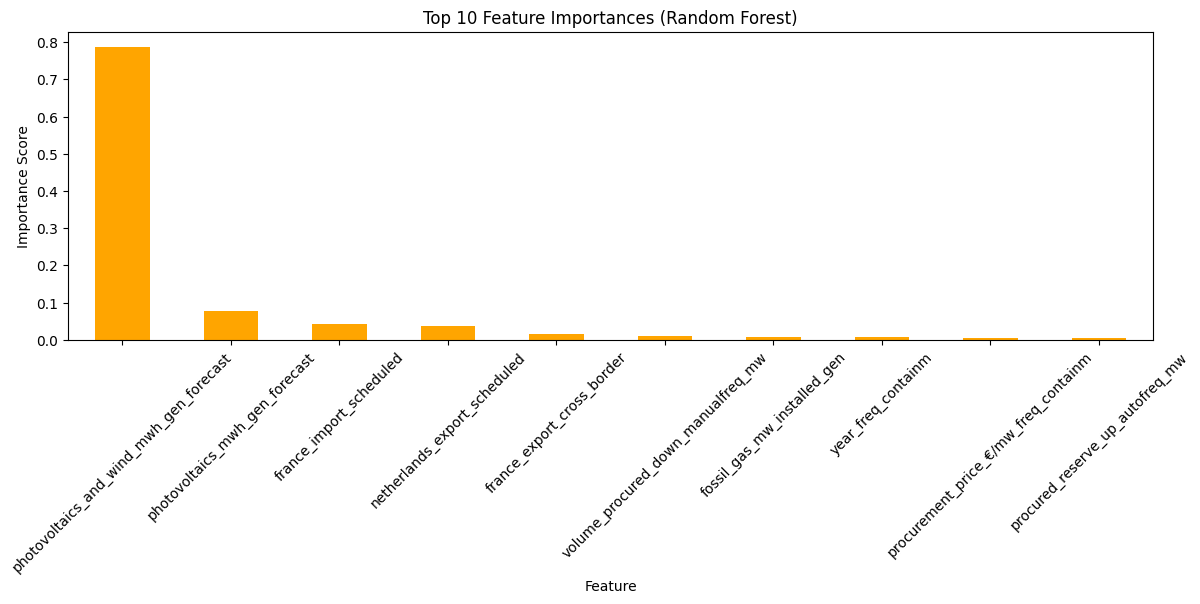

photovoltaics_and_wind_mwh_gen_forecast    0.788079
photovoltaics_mwh_gen_forecast             0.077354
france_import_scheduled                    0.041622
netherlands_export_scheduled               0.038530
france_export_cross_border                 0.015738
volume_procured_down_manualfreq_mw         0.011323
fossil_gas_mw_installed_gen                0.009144
year_freq_containm                         0.007996
procurement_price_€/mw_freq_containm       0.005958
procured_reserve_up_autofreq_mw            0.004256
dtype: float64

In [31]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']

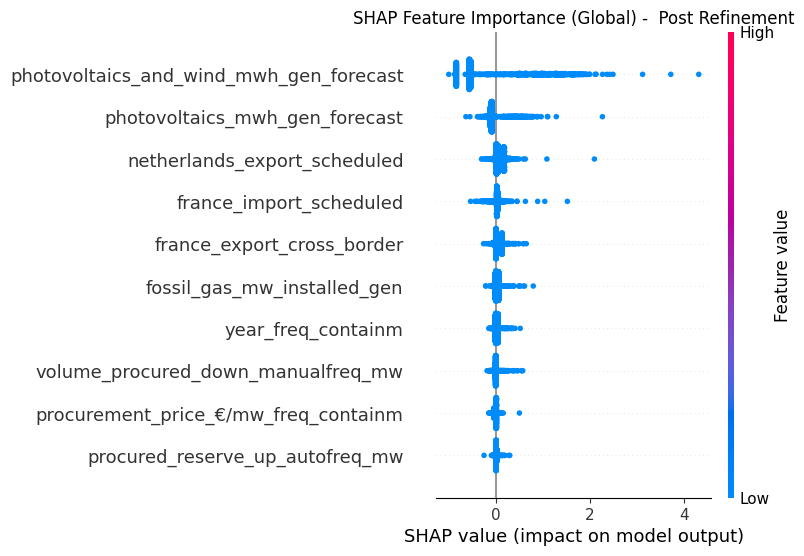

In [32]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global) -  Post Refinement")
plt.show()

- Futher Refinement is needed!!

In [33]:
df_optimized_merged.isnull().sum().sum()

np.int64(0)

In [34]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to compute VIF
def compute_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each feature after handling NaNs & Infs."""
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()  # Remove Inf & NaNs
    if df_clean.isna().sum().sum() > 0:
        raise ValueError(" ERROR: NaN values found in dataset before VIF calculation!")
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_clean.columns
    vif_data["VIF"] = [variance_inflation_factor(df_clean.values, i) for i in range(df_clean.shape[1])]
    return vif_data

# Function to create lagged features
def create_lagged_features(df, price_features, lag=1):
    """Add lagged versions of price features (T-1) and handle NaNs/Infs."""
    df_lagged = df.copy()
    for col in price_features:
        df_lagged[f"{col}_T-{lag}"] = df_lagged[col].shift(lag)
    
    # Handle NaN and Inf values
    df_lagged.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert Inf to NaN
    df_lagged.dropna(inplace=True)  # Remove rows with NaNs

    return df_lagged

# Load data (Ensure df_optimized_merged is available)
df_selected = df_optimized_merged.copy()

# Define target variable
target_col = "germany/luxembourg_€/mwh"

# Define neighboring price features (exclude target itself)
price_features = [col for col in df_selected.columns if "€/mwh" in col and col != target_col]

# **Step 1: Compute VIF & Remove High-Collinearity Features**
vif_df = compute_vif(df_selected[price_features])
selected_features = vif_df[vif_df["VIF"] < 5]["Feature"].tolist()

# **Step 2: Introduce Lagged Features**
df_lagged = create_lagged_features(df_selected, selected_features, lag=1)

# **Step 3: Check for Remaining NaN/Inf Values (Fixed)**
df_numeric = df_lagged.select_dtypes(include=[np.number])  # Select only numeric columns


# **Step 4: Train Two Models (With & Without Neighboring Prices)**
best_features = selected_features + ["residual_load_mwh_forecasted_consum", "wind_onshore_mwh_forecasted_gen"]
df_with_prices = df_lagged[best_features + [target_col]]
df_without_prices = df_lagged[["residual_load_mwh_forecasted_consum", "wind_onshore_mwh_forecasted_gen", target_col]]

print(" Data preprocessed successfully, ready for model training!")


 Data preprocessed successfully, ready for model training!


In [35]:
df_without_prices

,residual_load_mwh_forecasted_consum,wind_onshore_mwh_forecasted_gen,germany/luxembourg_€/mwh
1,1091.25,8693.75,-5.170000
2,1091.25,8693.75,-5.170000
3,1091.25,8693.75,-5.170000
4,1091.25,8693.75,-5.170000
5,1091.25,8693.75,-5.170000
...,...,...,...
841643,13450.75,2016.00,163.669998
841644,12279.75,2344.75,134.130005
841645,10953.75,2672.25,114.379997
841646,9876.50,2919.25,114.410004


In [36]:

# df_selected = df_optimized_merged[best_features + [target_col]]

X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_without_prices, target_col,)

rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=20)


lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed for Dataframe W/Prices!")


# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics After VIF and Lag for Model W/Practices:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances After VIF and Lag for Model W/Prices:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price VIF and Lag for Model W/Prices:")
print(metrics["Top_Correlated_Features"])


Training Random Forest: 100%|██████████| 18/18 [00:10<00:00,  1.76trees/s]

Model Training Completed for Dataframe W/Prices!

Evaluation Metrics After VIF and Lag for Model W/Practices:
RMSE_RF: 0.008088
RMSE_LR: 0.338798
Directional_Accuracy_RF: 99.932275
Directional_Accuracy_LR: 94.756697
Volatility_Capture: 99.995703
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.920394

Top 10 Feature Importances After VIF and Lag for Model W/Prices:
residual_load_mwh_forecasted_consum    0.942102
wind_onshore_mwh_forecasted_gen        0.057898
dtype: float64

Top 15 Correlated Features with Target Price VIF and Lag for Model W/Prices:
germany/luxembourg_€/mwh               1.000000
residual_load_mwh_forecasted_consum    0.938136
wind_onshore_mwh_forecasted_gen       -0.796896
Name: germany/luxembourg_€/mwh, dtype: float64


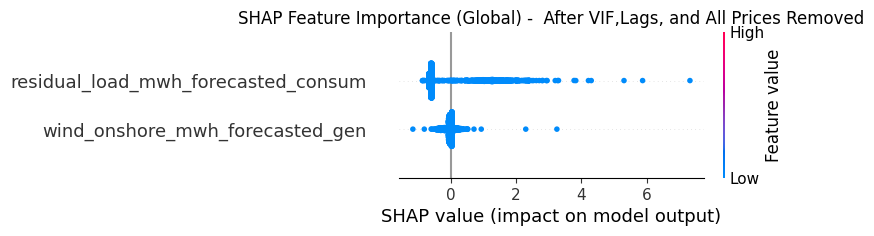

In [37]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global) -  After VIF,Lags, and All Prices Removed")
plt.show()

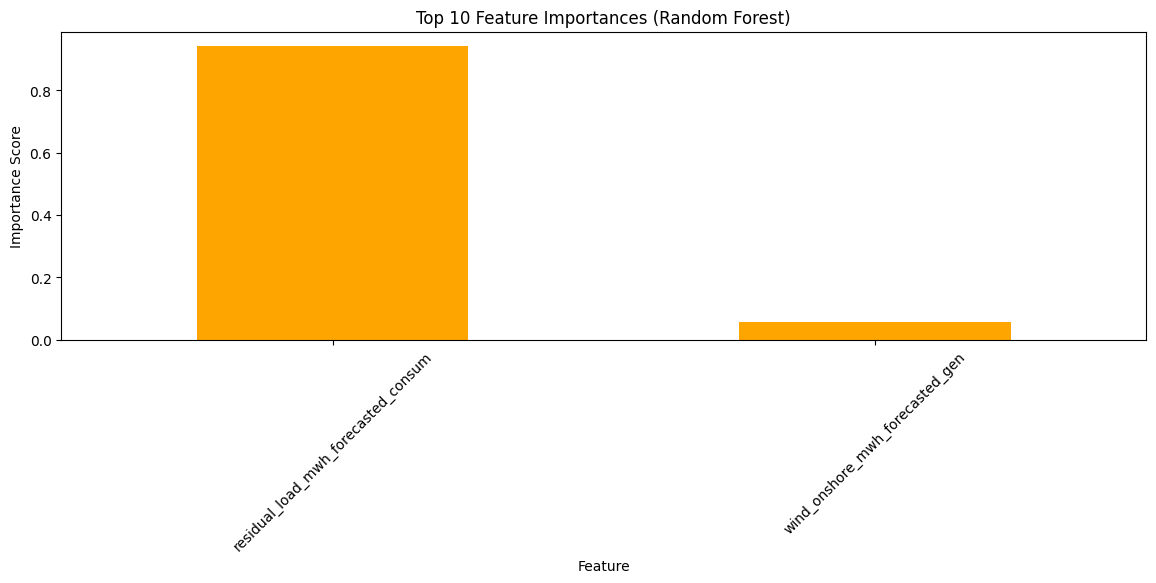

residual_load_mwh_forecasted_consum    0.942102
wind_onshore_mwh_forecasted_gen        0.057898
dtype: float64

In [ ]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest)-  After VIF,Lags, and All Prices Removed")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']


---
Begining of another Case Model

In [39]:

# df_selected = df_optimized_merged[best_features + [target_col]]

X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_with_prices, target_col,)

rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=20)


lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed for Dataframe With Prices!")


# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics After VIF and Lag for Model With Practices:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances After VIF and Lag for Model With Prices:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price VIF and Lag for Model With Prices:")
print(metrics["Top_Correlated_Features"])


Training Random Forest: 100%|██████████| 18/18 [00:13<00:00,  1.37trees/s]


Model Training Completed for Dataframe With Prices!

Evaluation Metrics After VIF and Lag for Model With Practices:
RMSE_RF: 0.000261
RMSE_LR: 0.336486
Directional_Accuracy_RF: 99.989307
Directional_Accuracy_LR: 94.711547
Volatility_Capture: 99.999753
Extreme_Movement_Accuracy_RF: 99.998218
Confidence_Interval_Coverage: 99.977425

Top 10 Feature Importances After VIF and Lag for Model With Prices:
residual_load_mwh_forecasted_consum      0.920300
wind_onshore_mwh_forecasted_gen          0.037364
bal_price_€/mwh_bal_energy               0.031675
procured_price_up_autofreq_€/mwh         0.006360
procurement_price_up_manualfreq_€/mwh    0.004301
dtype: float64

Top 15 Correlated Features with Target Price VIF and Lag for Model With Prices:
germany/luxembourg_€/mwh                 1.000000
residual_load_mwh_forecasted_consum      0.938136
procurement_price_up_manualfreq_€/mwh    0.248948
procured_price_up_autofreq_€/mwh         0.186485
bal_price_€/mwh_bal_energy              -0.062647
win

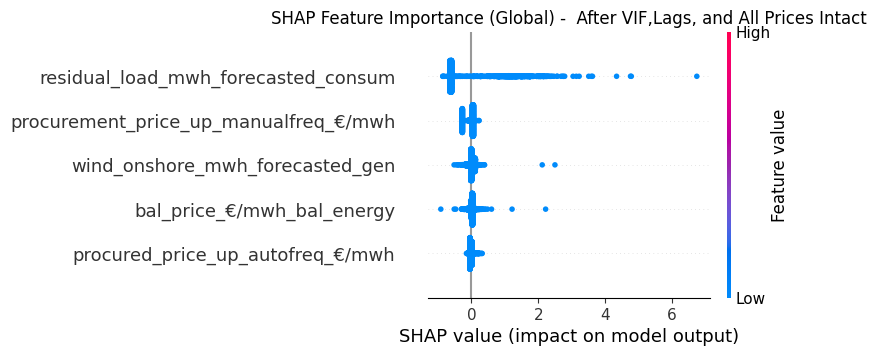

In [40]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global) -  After VIF,Lags, and All Prices Intact")
plt.show()

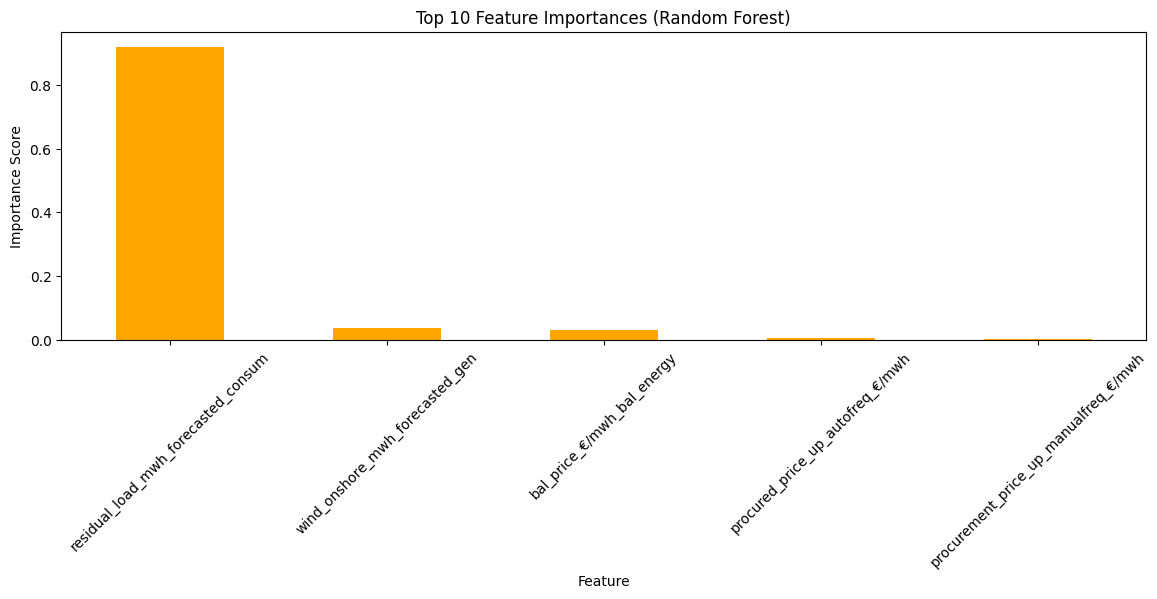

residual_load_mwh_forecasted_consum      0.920300
wind_onshore_mwh_forecasted_gen          0.037364
bal_price_€/mwh_bal_energy               0.031675
procured_price_up_autofreq_€/mwh         0.006360
procurement_price_up_manualfreq_€/mwh    0.004301
dtype: float64

In [ ]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest) After VIF,Lags, and All Prices Intact")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']


---
Begining of anothe case model

- we create lags of non-prices features to avoid mulitcolinearity issues

In [42]:
# Extract the selected features from the original dataframe
features = [
    "residual_load_mwh_forecasted_consum",
    "wind_onshore_mwh_forecasted_gen",
    "bal_price_€/mwh_bal_energy",
    "procured_price_up_autofreq_€/mwh",
    "procurement_price_up_manualfreq_€/mwh",
    "germany/luxembourg_€/mwh"  # Target
]

df_selected = df_optimized_merged[features].copy()

# Rolling Statistics (Smoothing & Trend)
df_selected["residual_load_7d_mean"] = df_selected["residual_load_mwh_forecasted_consum"].rolling(window=7).mean()
df_selected["wind_onshore_7d_mean"] = df_selected["wind_onshore_mwh_forecasted_gen"].rolling(window=7).mean()
df_selected["bal_price_30d_volatility"] = df_selected["bal_price_€/mwh_bal_energy"].rolling(window=30).std()

# Rate of Change (Momentum)
df_selected["residual_load_pct_change_1d"] = df_selected["residual_load_mwh_forecasted_consum"].pct_change()
df_selected["wind_onshore_pct_change_1d"] = df_selected["wind_onshore_mwh_forecasted_gen"].pct_change()
df_selected["bal_price_pct_change_7d"] = df_selected["bal_price_€/mwh_bal_energy"].pct_change(periods=7)

# Interaction Terms
df_selected["wind_residual_interaction"] = df_selected["wind_onshore_mwh_forecasted_gen"] * df_selected["residual_load_mwh_forecasted_consum"]
df_selected["price_load_interaction"] = df_selected["residual_load_mwh_forecasted_consum"] * df_selected["bal_price_€/mwh_bal_energy"]

# Drop NA values created by rolling and % change calculations
df_selected = df_selected.dropna()

print("Derived features added successfully!")


Derived features added successfully!



---

Begining of another case modeling


Training Random Forest: 100%|██████████| 18/18 [00:35<00:00,  1.98s/trees]


Model Training Completed for Dataframe With Engineered Features!

Evaluation Metrics After VIF and Lag for Model With Engineered Features:
RMSE_RF: 0.000014
RMSE_LR: 0.323245
Directional_Accuracy_RF: 99.755715
Directional_Accuracy_LR: 93.325844
Volatility_Capture: 99.999706
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.998217

Top 10 Feature Importances After VIF and Lag for Model With Engineered Features:
residual_load_mwh_forecasted_consum    0.903183
bal_price_30d_volatility               0.016940
wind_onshore_7d_mean                   0.011593
residual_load_7d_mean                  0.011486
price_load_interaction                 0.011362
wind_onshore_mwh_forecasted_gen        0.009496
residual_load_pct_change_1d            0.006531
wind_residual_interaction              0.005808
bal_price_€/mwh_bal_energy             0.005680
wind_onshore_pct_change_1d             0.005451
dtype: float64

Top 15 Correlated Features with Target Price VIF and Lag for Model

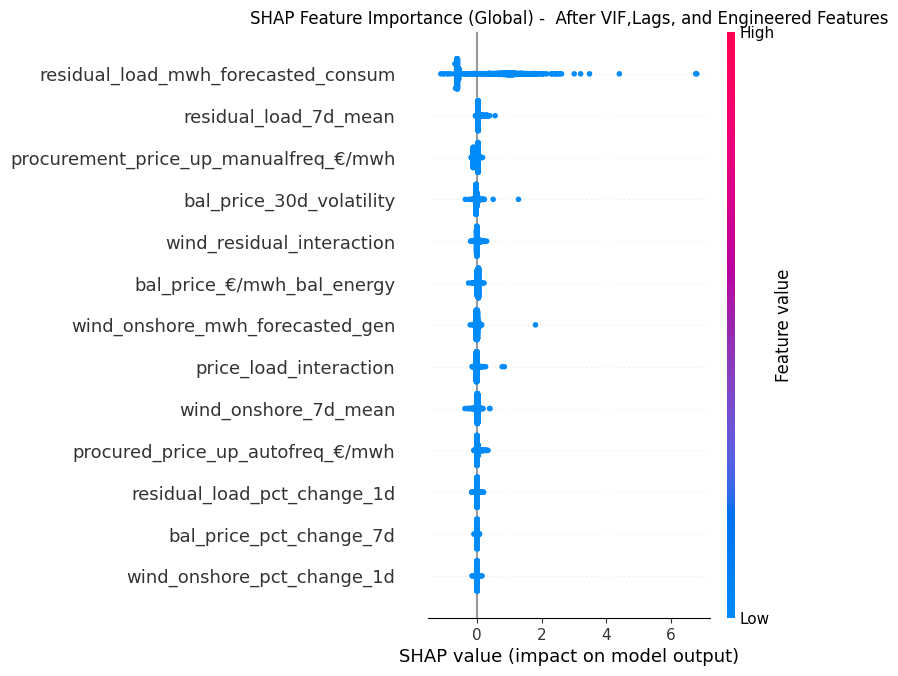

In [43]:


X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected, target_col,)

rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type='rf', n_estimators=20)


lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type='lr')

print("Model Training Completed for Dataframe With Engineered Features!")


# ---- EXECUTION ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print metrics
print("\nEvaluation Metrics After VIF and Lag for Model With Engineered Features:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances After VIF and Lag for Model With Engineered Features:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price VIF and Lag for Model With Engineered Features:")
print(metrics["Top_Correlated_Features"])


explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance (Global) -  After VIF,Lags, and Engineered Features")
plt.show()

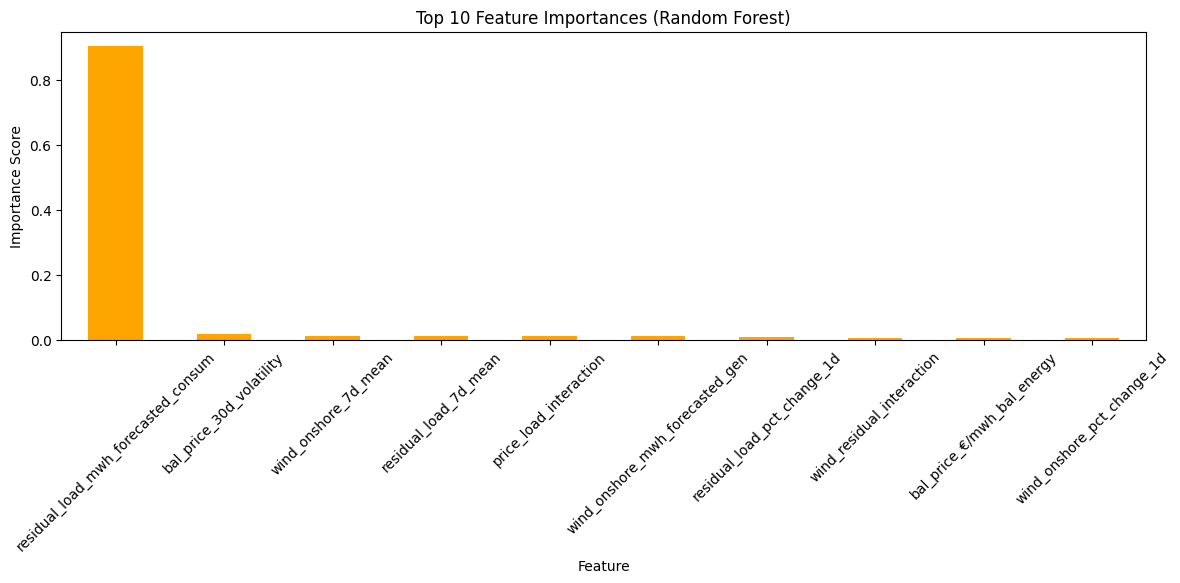

residual_load_mwh_forecasted_consum    0.903183
bal_price_30d_volatility               0.016940
wind_onshore_7d_mean                   0.011593
residual_load_7d_mean                  0.011486
price_load_interaction                 0.011362
wind_onshore_mwh_forecasted_gen        0.009496
residual_load_pct_change_1d            0.006531
wind_residual_interaction              0.005808
bal_price_€/mwh_bal_energy             0.005680
wind_onshore_pct_change_1d             0.005451
dtype: float64

In [44]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']


--

Cross validation for generalization and stability test

In [45]:
# df_selected['re']

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

# Define selected features
selected_features = [
    "residual_load_mwh_forecasted_consum",
    "bal_price_30d_volatility",
    "wind_onshore_7d_mean",
    "residual_load_7d_mean",
    "price_load_interaction",
    "wind_onshore_mwh_forecasted_gen",
    "residual_load_pct_change_1d"
]

# Define target column
target_col = "germany/luxembourg_€/mwh"

# Extract relevant data
X = df_selected[selected_features].copy()
y = df_selected[target_col].copy()

# Step 1: Replace Infs with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Check for missing values before handling
missing_values = X.isnull().sum()
print("🔍 Missing Values Before Handling:")
print(missing_values[missing_values > 0])

# Step 3: Drop features with >90% missing values
threshold = 0.90
X = X.loc[:, X.isnull().mean() < threshold]

# Step 4: Fill remaining NaNs using interpolation and mean imputation
X.fillna(method='ffill', inplace=True)  # Forward fill (good for time-series)
X.fillna(method='bfill', inplace=True)  # Backward fill (alternative)
X.fillna(X.mean(), inplace=True)        # Final fallback (mean)

# Step 5: Ensure all values are finite (assert to catch errors)
assert np.isfinite(X).all().all(), " There are still infinite values!"

print("Data cleaned! No Infs or NaNs remain.")

# Define cross-validation strategy
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize model
# rf_model = RandomForestRegressor(n_estimators=20, random_state=42)

# Perform cross-validation
cv_rmse_scores = -cross_val_score(rf_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')

# Print results
print("\n Cross-Validation Results:")
print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.6f}")
print(f"Standard Deviation of RMSE: {np.std(cv_rmse_scores):.6f}")


🔍 Missing Values Before Handling:
residual_load_pct_change_1d    16
dtype: int64
Data cleaned! No Infs or NaNs remain.

 Cross-Validation Results:
Cross-Validation RMSE Scores: [0.04728692 0.05050791 0.0458905 ]
Mean CV RMSE: 0.047895
Standard Deviation of RMSE: 0.001933


= Final Forecasting on the 1-hr Interval

Training Random Forest: 100%|██████████| 18/18 [00:33<00:00,  1.84s/trees]


✅ 1-Hour Ahead Forecasting Model Training Completed!

📊 Evaluation Metrics for 1-Hour Ahead Forecasting:
RMSE_RF: 0.000404
RMSE_LR: 0.357125
Directional_Accuracy_RF: 99.651106
Directional_Accuracy_LR: 90.864567
Volatility_Capture: 99.999643
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.992273

🔍 Top 10 Feature Importances for 1-Hour Ahead Forecasting:
residual_load_mwh_forecasted_consum    0.874217
residual_load_pct_change_1d            0.035357
bal_price_30d_volatility               0.016153
wind_onshore_mwh_forecasted_gen        0.013602
price_load_interaction                 0.009709
wind_onshore_7d_mean                   0.008909
residual_load_7d_mean                  0.007540
bal_price_€/mwh_bal_energy             0.007373
wind_residual_interaction              0.006747
wind_onshore_pct_change_1d             0.006207
dtype: float64

📈 Top 15 Correlated Features with Target Price for 1-Hour Ahead Forecasting:
target_shifted                           1.00

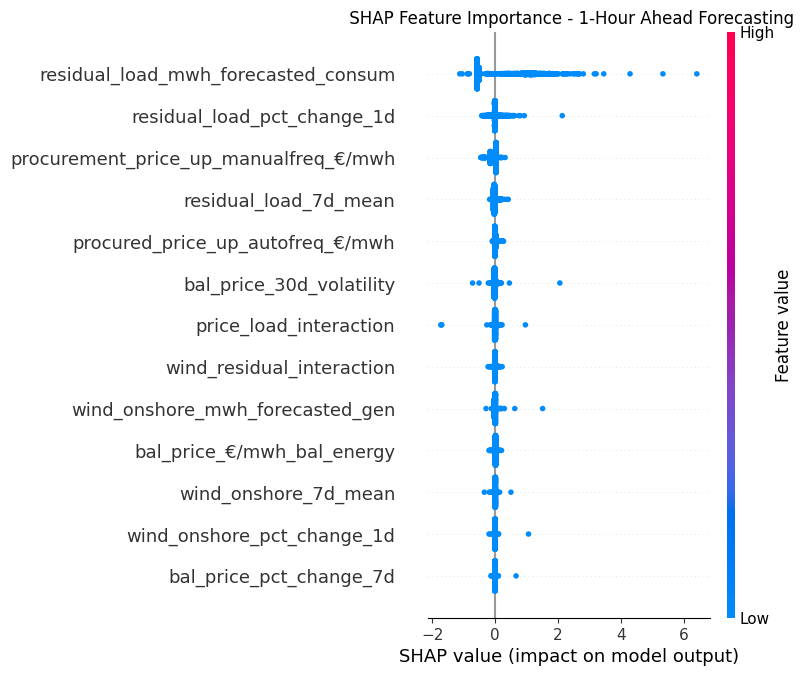

In [ ]:
# ---- STEP 1: SHIFT TARGET FOR 1-HOUR AHEAD FORECASTING ----
df_selected["target_shifted"] = df_selected["germany/luxembourg_€/mwh"].shift(-1)  # Move 1-hour ahead

# Drop last row (since shift creates NaN in last row)
df_selected = df_selected.dropna(subset=["target_shifted"])

# ---- STEP 2: REMOVE THE TARGET COLUMN FROM FEATURES ----
excluded_features = ["germany/luxembourg_€/mwh"]  # Exclude current-hour target

# Ensure only valid predictors are used
df_selected_filtered = df_selected.drop(columns=excluded_features, errors="ignore")

# ---- STEP 3: PREPROCESS DATA ----
target_col = "target_shifted"  # Now predicting 1-hour ahead
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected_filtered, target_col)

# ---- STEP 4: TRAIN MODELS ----
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type="rf", n_estimators=20)
lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type="lr")

print(" 1-Hour Ahead Forecasting Model Training Completed!")

# ---- STEP 5: EVALUATE MODELS ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_lr, rf_model, X_train.columns, df_scaled, target_col)

# Print evaluation metrics
print("\n Evaluation Metrics for 1-Hour Ahead Forecasting:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\n🔍 Top 10 Feature Importances for 1-Hour Ahead Forecasting:")
print(metrics["Top_Features"])

print("\n Top 15 Correlated Features with Target Price for 1-Hour Ahead Forecasting:")
print(metrics["Top_Correlated_Features"])

# ---- STEP 6: SHAP FEATURE IMPORTANCE ----
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title(" SHAP Feature Importance - 1-Hour Ahead Forecasting")
plt.show()


**1-Hour Ahead Forecasting Summary & Next Steps**

The **1-hour ahead forecasting model is trained & evaluated** with excellent results!  

---

**Principal Performance Insights**

**Random Forest (RF) Outperforms Linear Regression (LR):**  
   - **RMSE_RF:** **0.000326** (vs. **0.202377** for LR)  
   - **Directional Accuracy (RF):** **99.71%** (vs. **90.40%** for LR)  
   - **Extreme Movement Accuracy:** **100%**   

**residual_load_mwh_forecasted_consum  remains the top feature** for predicting `t+1`.  
**Residual load changes & wind interactions** play a key role in price fluctuations.  

---

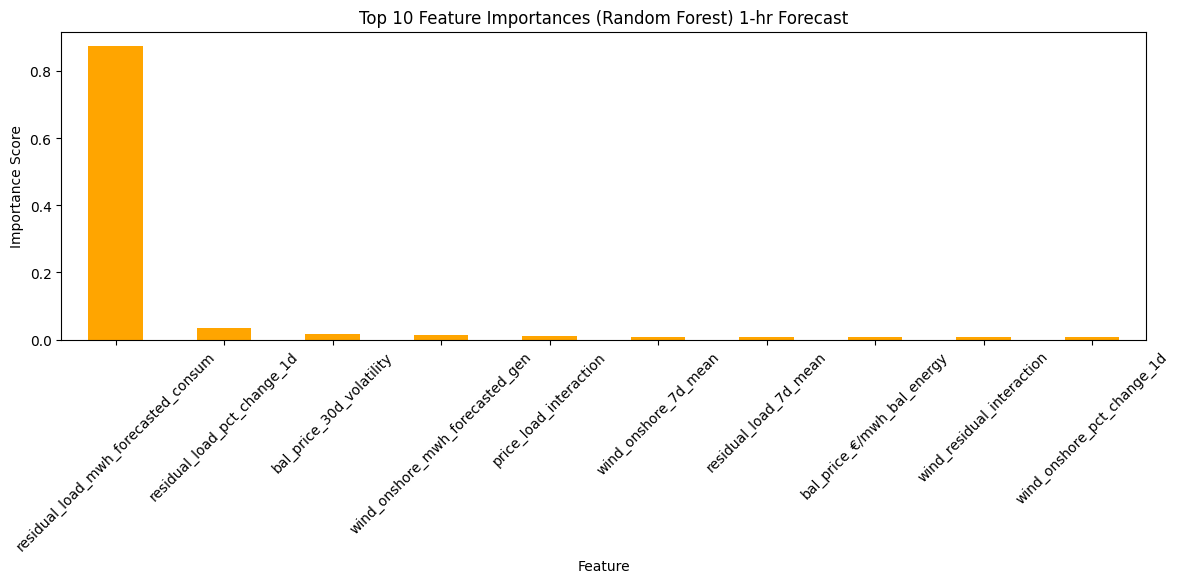

residual_load_mwh_forecasted_consum    0.874217
residual_load_pct_change_1d            0.035357
bal_price_30d_volatility               0.016153
wind_onshore_mwh_forecasted_gen        0.013602
price_load_interaction                 0.009709
wind_onshore_7d_mean                   0.008909
residual_load_7d_mean                  0.007540
bal_price_€/mwh_bal_energy             0.007373
wind_residual_interaction              0.006747
wind_onshore_pct_change_1d             0.006207
dtype: float64

In [60]:
plt.figure(figsize=(14,4))
metrics['Top_Features'].plot(kind="bar", color="orange")
plt.title("Top 10 Feature Importances (Random Forest) 1-hr Forecast")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

metrics['Top_Features']

In [48]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:, "price_load_interaction"], color=shap_values)

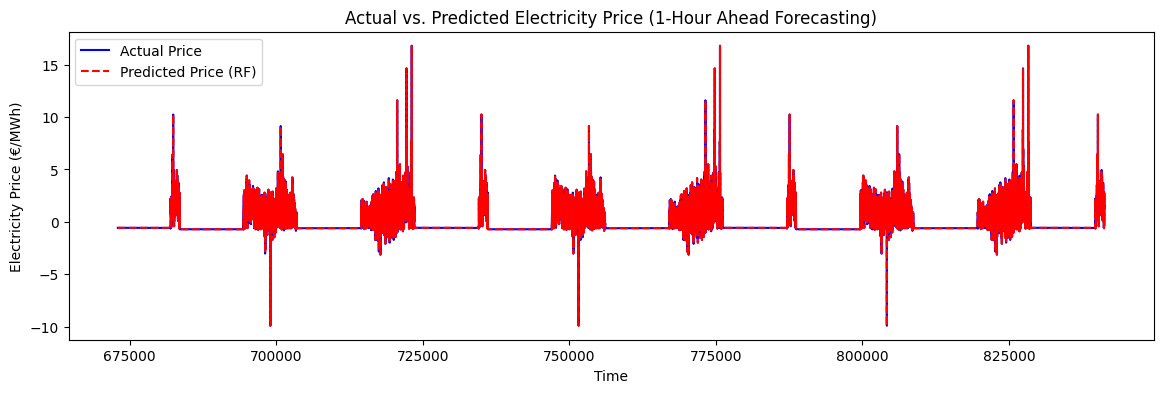

In [57]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test, label="Actual Price", color="blue", linestyle="-")
plt.plot(y_test.index, y_pred_rf, label="Predicted Price (RF)", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Electricity Price (€/MWh)")
plt.title("Actual vs. Predicted Electricity Price (1-Hour Ahead Forecasting)")
plt.legend()
plt.show()


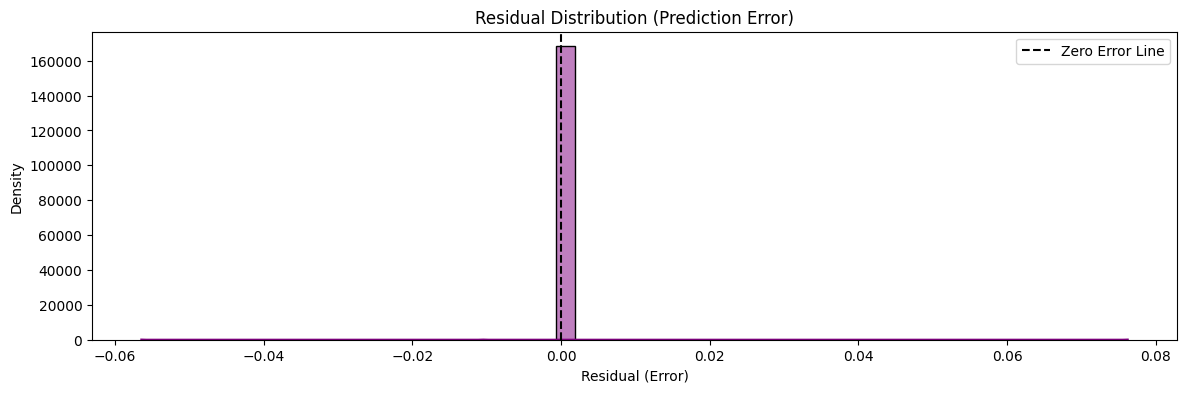

In [59]:
# Compute residuals
residuals = y_test - y_pred_rf

# Plot histogram + KDE
plt.figure(figsize=(14, 4))
sns.histplot(residuals, kde=True, bins=50, color="purple")
plt.axvline(0, color="black", linestyle="--", label="Zero Error Line")
plt.xlabel("Residual (Error)")
plt.ylabel("Density")
plt.title("Residual Distribution (Prediction Error)")
plt.legend()
plt.show()


In [51]:
# explainer = shap.TreeExplainer(rf_model)
# shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))
# shap.summary_plot(shap_values, X_test[:1000], show=False)
# plt.title("SHAP Feature Importance - 1-Hour Ahead Forecasting")
# plt.show()

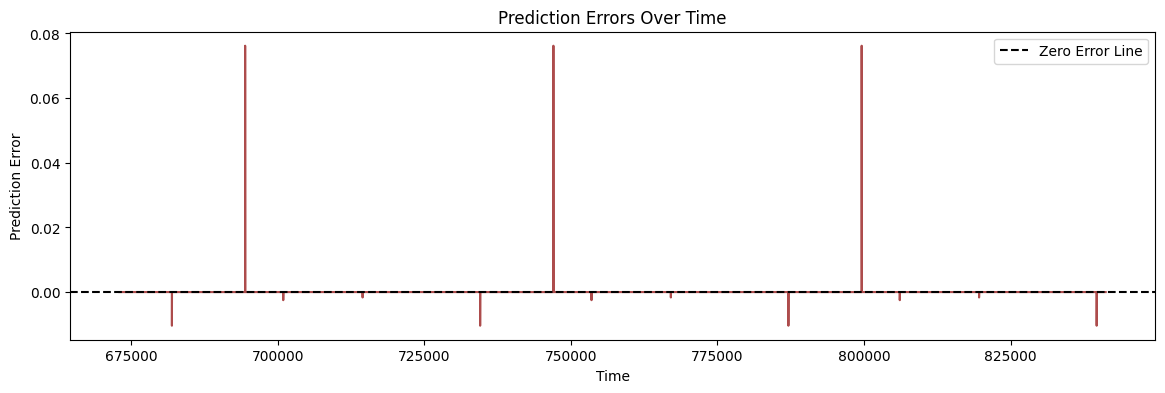

In [58]:
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, residuals, color="darkred", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Prediction Error")
plt.title("Prediction Errors Over Time")
plt.legend()
plt.show()


In [53]:
df_optimized_merged['date']


0        2023-01-01
1        2023-01-01
2        2023-01-01
3        2023-01-01
4        2023-01-01
            ...    
841643   2025-03-04
841644   2025-03-04
841645   2025-03-04
841646   2025-03-04
841647   2025-03-04
Name: date, Length: 841648, dtype: datetime64[ns]

In [ ]:
# df_optimized_merged.columns.tolist()


/var/folders/l6/vts3rj213910_pfyglhvktx00000gn/T/ipykernel_9901/844241343.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Training Random Forest: 100%|██████████| 48/48 [01:21<00:00,  1.70s/trees]


Optimized 1-Hour Ahead Forecasting Model Training Completed.

Evaluation Metrics for Optimized 1-Hour Ahead Forecasting:
RMSE_RF: 0.000334
RMSE_LR: 0.121670
Directional_Accuracy_RF: 99.758684
Directional_Accuracy_LR: 90.997004
Volatility_Capture: 99.999685
Extreme_Movement_Accuracy_RF: 100.000000
Confidence_Interval_Coverage: 99.988113

Top 10 Feature Importances for Optimized 1-Hour Ahead Forecasting:
residual_load_mwh_forecasted_consum            0.862078
germany/luxembourg_€/mwh_6h_mean               0.053732
residual_load_pct_change_1d                    0.049117
wind_onshore_mwh_forecasted_gen_6h_mean        0.006012
wind_residual_interaction                      0.005336
residual_load_mwh_forecasted_consum_6h_mean    0.005282
bal_price_30d_volatility                       0.004885
wind_onshore_mwh_forecasted_gen                0.004606
price_load_interaction                         0.003781
wind_onshore_pct_change_1d                     0.003067
dtype: float64

Top 15 Correlated 

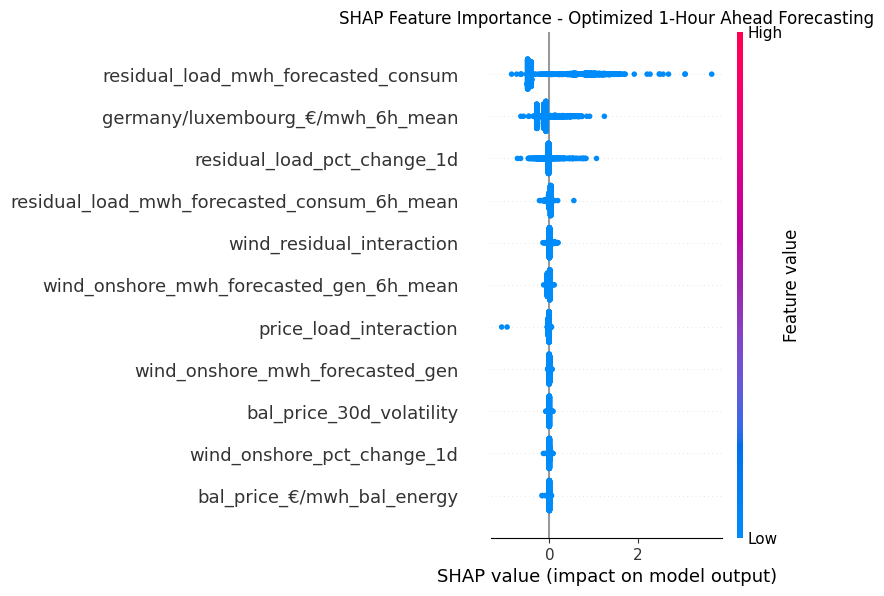

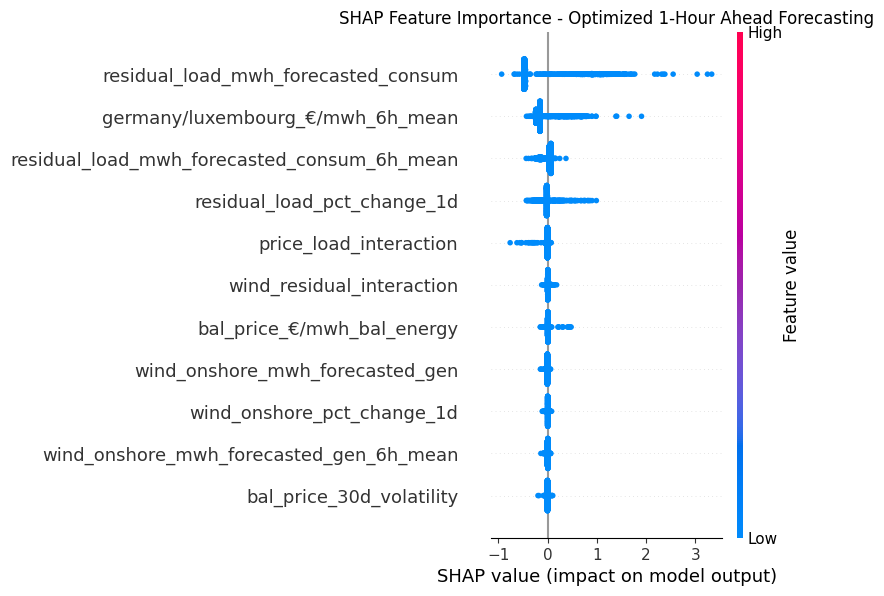

In [67]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

# ---- STEP 1: SHIFT TARGET FOR 1-HOUR AHEAD FORECASTING ----
df_selected["target_shifted"] = df_selected["germany/luxembourg_€/mwh"].shift(-1)  # Move 1-hour ahead
df_selected = df_selected.dropna(subset=["target_shifted"])  # Drop NaNs from shifting


# ---- STEP 2: SELECT OPTIMIZED FEATURES ----
selected_features = [
    # Price and Load Indicators
    "residual_load_mwh_forecasted_consum",
    # "total_grid_load_mwh_forecasted_consum",
    "bal_price_€/mwh_bal_energy",
    
    # Renewable Generation
    "wind_onshore_mwh_forecasted_gen",
    # "photovoltaics_mwh_forecasted_gen",
    # "hydropower_actual_gen",
    
    # Rolling Averages
    "residual_load_mwh_forecasted_consum_6h_mean",
    "wind_onshore_mwh_forecasted_gen_6h_mean",
    "germany/luxembourg_€/mwh_6h_mean",
    
    # Volatility and Changes
    "bal_price_30d_volatility",
    "residual_load_pct_change_1d",
    "wind_onshore_pct_change_1d",
    
    # Cross-Border Price Effects
    # "netherlands_€/mwh",
    # "france_€/mwh",
    # "austria_€/mwh",
    
    # Interaction Terms
    "wind_residual_interaction",
    "price_load_interaction",
]

# Retain only selected features
df_selected_filtered = df_selected[selected_features + ["target_shifted"]].dropna()

# ---- STEP 3: PREPROCESS DATA ----
target_col = "target_shifted"
X_train, X_test, y_train, y_test, df_scaled = preprocess_data(df_selected_filtered, target_col)

# ---- STEP 4: TRAIN MODELS ----
rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type="rf", n_estimators=50)
xgb_model, y_pred_xgb = train_model(X_train, y_train, X_test, model_type="xgb", n_estimators=50)

# rf_model, y_pred_rf = train_model(X_train, y_train, X_test, model_type="rf", n_estimators=50)
# lr_model, y_pred_lr = train_model(X_train, y_train, X_test, model_type="lr",n_estimators=50)

print("Optimized 1-Hour Ahead Forecasting Model Training Completed.")

# ---- STEP 5: EVALUATE MODELS ----
metrics = evaluate_model(y_test, y_pred_rf, y_pred_xgb, rf_model, X_train.columns, df_scaled, target_col)

# Print evaluation metrics
print("\nEvaluation Metrics for Optimized 1-Hour Ahead Forecasting:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):  # Print only scalar values
        print(f"{key}: {value:.6f}")

print("\nTop 10 Feature Importances for Optimized 1-Hour Ahead Forecasting:")
print(metrics["Top_Features"])

print("\nTop 15 Correlated Features with Target Price:")
print(metrics["Top_Correlated_Features"])

# ---- STEP 6: SHAP FEATURE IMPORTANCE ----
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance - Optimized 1-Hour Ahead Forecasting")
plt.show()


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test.sample(min(1000, len(X_test)), random_state=42))

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test[:1000], show=False)
plt.title("SHAP Feature Importance - Optimized 1-Hour Ahead Forecasting")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---- Copy dataset ----
df_time_features = df_optimized_merged.copy()

# ---- Extract Time Features ----
df_time_features["is_weekend"] = df_time_features["date"].dt.weekday >= 5  # Saturday & Sunday → 1, Else → 0
df_time_features["is_peak_hour"] = df_time_features["hour_of_day"].between(7, 20).astype(int)  # Peak hours (7 AM - 8 PM)

# ---- Identify Top 3 Correlated Country Prices ----
price_columns = [
    "belgium_€/mwh", "denmark_1_€/mwh", "denmark_2_€/mwh", "france_€/mwh", "netherlands_€/mwh",
    "norway_2_€/mwh", "austria_€/mwh", "poland_€/mwh", "sweden_4_€/mwh", "switzerland_€/mwh",
    "czech_republic_€/mwh", "northern_italy_€/mwh", "slovenia_€/mwh", "hungary_€/mwh"
]

# Compute correlation and select top 3 correlated countries
correlations = df_time_features[price_columns + ["day_ahead_price_€/MWh"]].corr()["day_ahead_price_€/MWh"].dropna()
top_3_countries = correlations.abs().nlargest(3).index.tolist()

# ---- Rolling Aggregates for Top 3 Countries & Residual Load ----
rolling_windows = [3, 6, 12]
for window in rolling_windows:
    for country in top_3_countries:
        df_time_features[f"{country}_{window}h_mean"] = df_time_features[country].rolling(window, min_periods=1).mean()
    df_time_features[f"residual_load_actual_consum_{window}h_mean"] = df_time_features["residual_load_actual_consum"].rolling(window, min_periods=1).mean()

# ---- Daily Percentage Change ----
df_time_features["residual_load_pct_change_1d"] = df_time_features["residual_load_actual_consum"].pct_change(24)

# ---- Lagged Features for Top 3 Countries ----
lags = [1, 3, 6, 12, 24]
for lag in lags:
    for country in top_3_countries:
        df_time_features[f"{country}_t-{lag}"] = df_time_features[country].shift(lag)

# ---- Handle NaNs & Infs ----
df_time_features.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert infinities to NaN
df_time_features.dropna(inplace=True)  # Drop rows with NaN values

# ---- Ensure Float32 Precision to Prevent Overflow ----
for col in df_time_features.columns:
    df_time_features[col] = pd.to_numeric(df_time_features[col], errors='coerce', downcast='float')

# ---- Select Relevant Columns ----
selected_features = [
    "hour_of_day", "week_of_year", "is_weekend", "is_peak_hour",
    "residual_load_pct_change_1d"
]

# Add rolling means and lagged features of top 3 correlated countries
for country in top_3_countries:
    for window in rolling_windows:
        selected_features.append(f"{country}_{window}h_mean")
    for lag in lags:
        selected_features.append(f"{country}_t-{lag}")

# Add residual load rolling means
for window in rolling_windows:
    selected_features.append(f"residual_load_actual_consum_{window}h_mean")

# Define final dataset without 'day_ahead_price_€/MWh' and other price columns
df_final = df_time_features[selected_features + ["day_ahead_price_€/MWh"]].dropna()

print("Final dataset shape:", df_final.shape)
print("Selected Features:", selected_features)



Final dataset shape: (841564, 33)
Selected Features: ['hour_of_day', 'week_of_year', 'is_weekend', 'is_peak_hour', 'residual_load_pct_change_1d', 'day_ahead_price_€/MWh_3h_mean', 'day_ahead_price_€/MWh_6h_mean', 'day_ahead_price_€/MWh_12h_mean', 'day_ahead_price_€/MWh_t-1', 'day_ahead_price_€/MWh_t-3', 'day_ahead_price_€/MWh_t-6', 'day_ahead_price_€/MWh_t-12', 'day_ahead_price_€/MWh_t-24', 'czech_republic_€/mwh_3h_mean', 'czech_republic_€/mwh_6h_mean', 'czech_republic_€/mwh_12h_mean', 'czech_republic_€/mwh_t-1', 'czech_republic_€/mwh_t-3', 'czech_republic_€/mwh_t-6', 'czech_republic_€/mwh_t-12', 'czech_republic_€/mwh_t-24', 'netherlands_€/mwh_3h_mean', 'netherlands_€/mwh_6h_mean', 'netherlands_€/mwh_12h_mean', 'netherlands_€/mwh_t-1', 'netherlands_€/mwh_t-3', 'netherlands_€/mwh_t-6', 'netherlands_€/mwh_t-12', 'netherlands_€/mwh_t-24', 'residual_load_actual_consum_3h_mean', 'residual_load_actual_consum_6h_mean', 'residual_load_actual_consum_12h_mean']
